## 方案3：CovnLSTM采用预测未来一帧图像，然后再循环三次使得能够预测未来3帧图像

### 数据预处理模块

从压缩文件中提取图像文件，按风暴ID分组，并将图像数据集根据ID划分为训练集（0.8）和验证集（0.2）。使得验证集和训练集中都有各种类型的样本。随后，定义自定义的PyTorch数据集类，加载和处理这些图像数据，最终创建数据加载器以供模型训练和验证。

### 具体思路

1. **加载并排序图像文件**:
   - 调用`load_images_sorted`函数加载并排序解压后的图像文件。

2. **按风暴ID分组图像**:
   - 使用`defaultdict`创建一个字典，将图像文件按风暴ID分组。
   - 遍历所有图像文件，提取风暴ID并加入相应分组。

3. **划分训练集和验证集**:
   - 定义训练集和验证集的划分比例为0.8。
   - 对每个风暴类型的图像文件按照比例划分为训练集和验证集。
   - 计算分割点，将前80%的图像分配给训练集，剩余的20%分配给验证集。

4. **提取图像信息**:
   - 分别调用`extract_all_image_info`函数，提取训练集和验证集所有图像的风暴ID和时间信息。

5. **定义数据集类**:
   - 使用TyphoonDataset类创建训练集和验证集的数据集对象，设置序列长度为6（包括5个历史帧和1个预测帧）。

6. **创建数据加载器**:
   - 使用DataLoader创建训练集和验证集的数据加载器，设置批量大小。

In [1]:
import os
import re
import zipfile
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

# 从文件名中提取数字的辅助函数
def extract_number(filename):
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else 0

# 加载并排序图像文件
def load_images_sorted(directory):
    images = []
    for root, _, files in os.walk(directory):
        for fname in files:
            if fname.endswith('.jpg'):
                full_path = os.path.join(root, fname)
                images.append(full_path)
    images.sort(key=extract_number)
    return images

# 从文件名中提取风暴ID和时间的辅助函数
def extract_storm_id_and_time(filepath):
    filename = os.path.basename(filepath)
    parts = filename.split('_')
    storm_id = parts[0]
    time = parts[1].split('.')[0]
    return storm_id, time

# 提取所有图像信息的辅助函数
def extract_all_image_info(image_paths):
    all_image_info = []
    for path in image_paths:
        storm_id, time = extract_storm_id_and_time(path)
        all_image_info.append((storm_id, time))
    return all_image_info

# 解压缩文件
def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# 数据目录
zip_path = '/root/dashuju/data/storm.zip'
extract_to = '/root/dashuju/data/stormoutput'
extract_zip(zip_path, extract_to)

all_images = load_images_sorted(extract_to)

# 按风暴ID分组
storm_groups = defaultdict(list)
for img in all_images:
    storm_id, _ = extract_storm_id_and_time(img)
    storm_groups[storm_id].append(img)

# 分别对每个风暴类型按照比例进行划分
train_images = []
val_images = []
split_ratio = 0.8

for storm_id, images in storm_groups.items():
    split_point = int(len(images) * split_ratio)
    train_images.extend(images[:split_point])
    val_images.extend(images[split_point:])

# 提取训练集和验证集的所有图片信息
train_image_info = extract_all_image_info(train_images)
val_image_info = extract_all_image_info(val_images)

# 数据集类定义
class TyphoonDataset(Dataset):
    def __init__(self, image_paths, sequence_length=5, transform=None):
        self.image_paths = image_paths
        self.sequence_length = sequence_length
        self.transform = transform or transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.image_paths) - self.sequence_length + 1

    def __getitem__(self, idx):
        sequence_paths = self.image_paths[idx:idx + self.sequence_length]
        imgs = [Image.open(img_path).convert('RGB') for img_path in sequence_paths]
        if self.transform:
            imgs = [self.transform(img) for img in imgs]
        sequences = torch.stack(imgs[:-1])
        target = imgs[-1]  # 确保目标图像是 [1, height, width]
        return sequences, target

# 创建数据集和数据加载器
train_dataset = TyphoonDataset(train_images, sequence_length=7)  # 包含10个输入帧和1个输出帧
val_dataset = TyphoonDataset(val_images, sequence_length=7)
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=False, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=6, shuffle=False, drop_last=True)

"""
# 打印训练集和验证集的图片信息
print("Training set image info:")
for info in train_image_info:
    print(info)

print("\nValidation set image info:")
for info in val_image_info:
    print(info)
"""

'\n# 打印训练集和验证集的图片信息\nprint("Training set image info:")\nfor info in train_image_info:\n    print(info)\n\nprint("\nValidation set image info:")\nfor info in val_image_info:\n    print(info)\n'

### 函数详细描述

#### 1. extract_number(filename)
- **功能**: 从文件名中提取数字，用于排序图像文件。
- **输入**: `filename` (str) - 文件名。
- **输出**: 提取到的数字 (int)。如果没有找到则返回0。
- **实现思路**:
  - 使用正则表达式匹配文件名中的数字部分。
  - 返回匹配到的数字。

#### 2. load_images_sorted(directory)
- **功能**: 加载并排序指定目录中的所有图像文件。
- **输入**: `directory` (str) - 包含图像文件的目录。
- **输出**: 按文件名中的数字排序后的图像文件路径列表 (list)。
- **实现思路**:
  - 使用os.walk遍历目录，找到所有以“.jpg”结尾的文件并加入列表。
  - 使用`extract_number`函数对文件名进行排序。

#### 3. extract_storm_id_and_time(filepath)
- **功能**: 从文件路径中提取风暴ID和时间信息。
- **输入**: `filepath` (str) - 图像文件的路径。
- **输出**: 风暴ID (str) 和时间 (str)。
- **实现思路**:
  - 使用os.path.basename获取文件名。
  - 拆分文件名获得风暴ID和时间信息。

#### 4. extract_all_image_info(image_paths)
- **功能**: 提取所有图像路径中的风暴ID和时间信息。
- **输入**: `image_paths` (list) - 图像文件路径列表。
- **输出**: 包含风暴ID和时间信息的元组列表 (list)。
- **实现思路**:
  - 遍历所有图像路径，调用`extract_storm_id_and_time`函数提取信息。

#### 5. extract_zip(zip_path, extract_to)
- **功能**: 解压缩文件到指定目录。
- **输入**: `zip_path` (str) - 压缩文件路径；`extract_to` (str) - 解压缩目标目录。
- **输出**: 无。
- **实现思路**:
  - 使用`zipfile.ZipFile`打开并解压缩文件。

#### 6. TyphoonDataset
- **功能**: 自定义的PyTorch数据集类，用于加载和处理图像序列数据。
- **输入**: 
  - `image_paths` (list) - 图像文件路径列表。
  - `sequence_length` (int) - 序列长度。
  - `transform` (callable) - 图像转换方法。
- **输出**: 
  - `__len__` - 返回数据集长度。
  - `__getitem__` - 返回给定索引处的图像序列和目标图像。
- **实现思路**:
  - 初始化时接收图像路径列表、序列长度和图像转换方法。
  - `__len__`方法返回数据集长度。
  - `__getitem__`方法返回给定索引处的图像序列和目标图像。


In [2]:
import torch.optim as optim

### 模型定义模块

 定义卷积长短期记忆（ConvLSTM）网络，用于处理图像序列数据。ConvLSTM是一种适用于时空序列预测的模型，结合了卷积神经网络和LSTM的优点。包含两个主要部分：ConvLSTMCell和ConvLSTM，分别实现了ConvLSTM的单个细胞和多层网络结构。


In [3]:
import torch
import torch.nn as nn

class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, output_dim, bias=True):
        super(ConvLSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.bias = bias
        self.cell_list = nn.ModuleList()
        
        for i in range(self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i-1]
            self.cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                               hidden_dim=self.hidden_dim[i],
                                               kernel_size=self.kernel_size,
                                               bias=self.bias))
        
        self.conv = nn.Conv2d(in_channels=self.hidden_dim[-1],
                              out_channels=self.output_dim,
                              kernel_size=1,
                              padding=0,
                              bias=True)

    def forward(self, input_tensor, hidden_state=None):
        b, seq_len, _, h, w = input_tensor.size()
        if hidden_state is None:
            hidden_state = self._init_hidden(batch_size=b, image_size=(h, w))
        
        layer_output_list = []
        last_state_list = []

        cur_layer_input = input_tensor
        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :], cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append((h, c))

        predictions = self.conv(layer_output_list[-1][:, -1, :, :, :])
        return predictions, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states


### 函数详细描述

#### 1. ConvLSTMCell
- **功能**: 定义一个ConvLSTM细胞，用于处理输入的图像序列并更新隐藏状态。
- **输入**:
  - `input_tensor` (Tensor) - 当前时间步的输入张量，形状为(batch_size, input_dim, height, width)。
  - `cur_state` (Tuple[Tensor, Tensor]) - 当前时间步的隐藏状态(h_cur, c_cur)，每个张量的形状为(batch_size, hidden_dim, height, width)。
- **输出**:
  - `h_next` (Tensor) - 下一时间步的隐藏状态，形状为(batch_size, hidden_dim, height, width)。
  - `c_next` (Tensor) - 下一时间步的记忆状态，形状为(batch_size, hidden_dim, height, width)。
- **实现思路**:
  - 初始化卷积层，用于处理输入和隐藏状态的拼接。
  - 在`forward`方法中，将输入和当前隐藏状态拼接，经过卷积层得到四个门控信号。
  - 通过sigmoid和tanh函数计算输入门、遗忘门、输出门和新的记忆状态。
  - 更新记忆状态和隐藏状态并返回。

#### 2. init_hidden(batch_size, image_size)
- **功能**: 初始化隐藏状态和记忆状态。
- **输入**:
  - `batch_size` (int) - 批次大小。
  - `image_size` (Tuple[int, int]) - 图像的高度和宽度。
- **输出**: 
  - 初始化的隐藏状态和记忆状态，形状均为(batch_size, hidden_dim, height, width)。
- **实现思路**:
  - 创建全零张量作为初始隐藏状态和记忆状态。

#### 3. ConvLSTM
- **功能**: 定义一个多层ConvLSTM网络，用于处理图像序列并生成预测结果。
- **输入**:
  - `input_tensor` (Tensor) - 输入的图像序列，形状为(batch_size, seq_len, input_dim, height, width)。
  - `hidden_state` (Optional[List[Tuple[Tensor, Tensor]]]) - 初始隐藏状态和记忆状态，如果未提供则自动初始化。
- **输出**:
  - `predictions` (Tensor) - 最终的预测结果，形状为(batch_size, output_dim, height, width)。
  - `last_state_list` (List[Tuple[Tensor, Tensor]]) - 每一层最后的隐藏状态和记忆状态。
- **实现思路**:
  - 在初始化时创建一个ConvLSTMCell的列表，每层一个。
  - 在`forward`方法中，遍历输入序列并在每一层上进行时间步的循环，更新每一层的隐藏状态和记忆状态。
  - 最后使用卷积层将最后一层的输出转换为预测结果。

#### 4. _init_hidden(batch_size, image_size)
- **功能**: 初始化所有层的隐藏状态和记忆状态。
- **输入**:
  - `batch_size` (int) - 批次大小。
  - `image_size` (Tuple[int, int]) - 图像的高度和宽度。
- **输出**:
  - `init_states` (List[Tuple[Tensor, Tensor]]) - 包含每一层的初始隐藏状态和记忆状态。
- **实现思路**:
  - 调用每一层的init_hidden方法，初始化隐藏状态和记忆状态。


In [4]:
import torch.optim as optim

### 预测模块

  实现对ConvLSTM模型的训练和验证。通过定义模型、损失函数和优化器，进行多轮训练，并在每个周期后验证模型的性能。加入添加学习率调度器自动调整学习率。并绘制验证集和训练集的损失函数对比图。最后，保存模型的参数（包括优化器和模型参数）。
    
### 具体思路

1. **初始化模型、损失函数和优化器**:
   - 定义ConvLSTM模型，输入维度为1，隐藏维度为32的两层，卷积核大小为1x1，输出维度为1。
   - 使用MSELoss作为损失函数，Adam作为优化器，学习率设置为0.0001。
   - 使用学习率调度器，每5个周期后将学习率缩小到原来的10%。

2. **训练模型**:
   - 循环指定的epoch数，每个epoch包括训练和验证两个阶段。
   - 在训练阶段，将模型设为训练模式，循环每个batch，进行前向传播、计算损失、反向传播和参数更新。
   - 累加每个batch的训练损失，计算平均损失，并记录下来。
   - 在验证阶段，将模型设为评估模式，禁用梯度计算，循环每个batch，进行前向传播和损失计算。
   - 累加每个batch的验证损失，计算平均损失，并记录下来。

3. **输出结果**:
   - 在每个epoch结束后，打印当前epoch的训练损失和验证损失。


In [5]:
# 初始化模型、损失函数和优化器
model = ConvLSTM(input_dim=1, hidden_dim=[64, 64], kernel_size=(1, 1), num_layers=2, output_dim=1, bias=True)
model.cuda()  # 如果有GPU
criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.05)

for epoch in range(10):  # 设置所需的epoch数
    model.train()
    total_train_loss = 0
    for sequences, targets in train_loader:
        sequences = sequences.cuda()
        targets = targets.cuda()  # 确保目标维度是正确的 [batch_size, 1, height, width]
        optimizer.zero_grad()
        outputs, _ = model(sequences)
        train_loss = criterion(outputs, targets)
        train_loss.backward()
        optimizer.step()
        total_train_loss += train_loss.item()
    train_losses.append(total_train_loss / len(train_loader))
    
    scheduler.step()  # Step the scheduler
    
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for sequences, targets in val_loader:
            sequences = sequences.cuda()
            targets = targets.cuda()
            outputs, _ = model(sequences)
            val_loss = criterion(outputs, targets)
            total_val_loss += val_loss.item()
    val_losses.append(total_val_loss / len(val_loader))
    print(f'Epoch {epoch+1}, Train Loss: {total_train_loss / len(train_loader)}, Validation Loss: {total_val_loss / len(val_loader)}')

Epoch 1, Train Loss: 0.010355212246025557, Validation Loss: 0.0044739808405474205
Epoch 2, Train Loss: 0.005917117519038799, Validation Loss: 0.0044654079845816525
Epoch 3, Train Loss: 0.005895078905520706, Validation Loss: 0.004470519298495748
Epoch 4, Train Loss: 0.005820619930669771, Validation Loss: 0.004485646833126791
Epoch 5, Train Loss: 0.005820742940914985, Validation Loss: 0.004482011823642577
Epoch 6, Train Loss: 0.005820153658270936, Validation Loss: 0.004479027042237151
Epoch 7, Train Loss: 0.005821227401071585, Validation Loss: 0.004451214624700611
Epoch 8, Train Loss: 0.0058150114247174055, Validation Loss: 0.004452818052465412
Epoch 9, Train Loss: 0.005814850860148163, Validation Loss: 0.004453117957187863
Epoch 10, Train Loss: 0.005813797363001065, Validation Loss: 0.004452878438520579


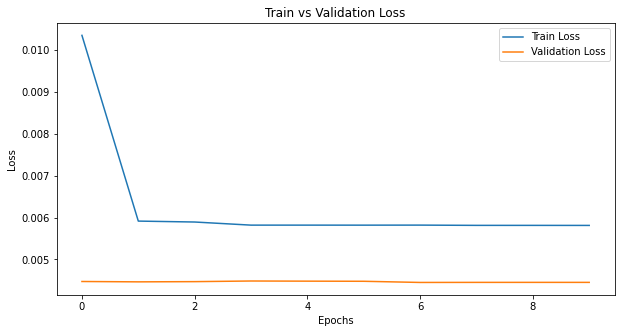

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [7]:
for sequences, targets in train_loader:
    sequences = sequences.cuda()
    targets = targets.cuda()
    outputs, _ = model(sequences)
    print("Output size:", outputs.size())  # 现在检查输出尺寸
    print("Target size:", targets.size())  # 检查目标尺寸
    break  # 仅检查第一个批次


Output size: torch.Size([6, 1, 128, 128])
Target size: torch.Size([6, 1, 128, 128])


In [8]:
import torch

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, '/root/dashuju/model/model2-6张.pth')

### 函数详细描述

#### 1. 初始化模型、损失函数和优化器
- **功能**: 定义ConvLSTM模型结构，选择损失函数和优化算法。
- **输入**:
  - `input_dim` (int) - 输入的通道数。
  - `hidden_dim` (list) - 每一层隐藏状态的通道数。
  - `kernel_size` (tuple) - 卷积核的大小。
  - `num_layers` (int) - ConvLSTM的层数。
  - `output_dim` (int) - 输出的通道数。
  - `bias` (bool) - 是否使用偏置。
- **输出**: 
  - 初始化的模型。
  - 损失函数。
  - 优化器。
- **实现思路**:
  - 使用定义好的ConvLSTM模型类初始化模型结构。
  - 使用MSELoss作为损失函数。
  - 使用Adam优化器，并设置学习率。
  - 如果有GPU，使用`model.cuda()`将模型移至GPU。

#### 2. 训练模型
- **功能**: 对模型进行训练，并记录每个epoch的训练损失。
- **输入**:
  - `train_loader` (DataLoader) - 训练数据加载器。
  - `val_loader` (DataLoader) - 验证数据加载器。
  - `num_epochs` (int) - 训练的周期数。
- **输出**: 
  - 训练损失列表。
  - 验证损失列表。
- **实现思路**:
  - 将模型设置为训练模式`model.train()`。
  - 对每个batch进行前向传播、计算损失、反向传播和优化器更新。
  - 累加每个batch的训练损失，并计算平均损失。
  - 使用学习率调度器更新学习率。

#### 3. 验证模型
- **功能**: 在验证集上评估模型的性能，并记录每个epoch的验证损失。
- **输入**:
  - `val_loader` (DataLoader) - 验证数据加载器。
- **输出**: 
  - 验证损失列表。
- **实现思路**:
  - 将模型设置为评估模式`model.eval()`。
  - 使用`torch.no_grad()`禁用梯度计算，以减少内存使用。
  - 对每个batch进行前向传播和损失计算。
  - 累加每个batch的验证损失，并计算平均损失。


In [9]:
# 反归一化函数
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5  # 反归一化到 [0, 1]
    tensor = tensor * 255.0  # 反归一化到 [0, 255]
    tensor = tensor.clamp(0, 255)  # 确保像素值在 [0, 255] 范围内
    return tensor.byte()  # 转换为无符号 8 位整数

In [10]:
# 计算信息熵
def calculate_entropy(image):
    hist, _ = np.histogram(image, bins=256, range=(0, 255))
    hist = hist / np.sum(hist)
    e = entropy(hist, base=2)
    return e

### 绘图预测模块

  实现绘制和保存图像的功能，以及使用ConvLSTM模型进行预测并评估预测结果的性能。通过定义绘图函数、加载模型和数据，进行图像预测，并计算评估指标（如MSE、PSNR、SSIM）和信息熵，最后绘制预测图像和真实图像的对比图。

### 实现思路

1. **绘制图像的函数**:
   - 定义`plot_and_save_images`函数，绘制和保存图像。

2. **加载模型和数据**:
   - 设置设备，将模型移至相应设备（CPU或GPU）。
   - 从验证数据加载器中获取一个样本，进行连续三次预测，保存预测结果。

3. **提取和绘制历史图像**:
   - 从验证集中提取历史图像路径和标签，并使用`plot_and_save_images`函数绘制和保存。

4. **评估预测结果**:
   - 计算评估指标（MSE、PSNR、SSIM）和信息熵，并记录每对真实图像和预测图像的结果。

5. **绘制预测图像和真实图像的对比图**:
   - 创建子图，并绘制每一对真实图像和预测图像。
   - 显示评估指标和信息熵。

In [11]:
# 加载模型
model = ConvLSTM(input_dim=1, hidden_dim=[64, 64], kernel_size=(1, 1), num_layers=2, output_dim=1, bias=True)
checkpoint = torch.load('/root/dashuju/model/model2-6张.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.cuda()
model.eval()

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
# 绘制图像的函数
def plot_and_save_images(images, titles=None, title='Images', save_path=''):
    num_images = len(images)
    fig, axes = plt.subplots(2, num_images // 2, figsize=(20, 10))
    axes = axes.flatten()
    for i, img_tensor in enumerate(images):
        if isinstance(img_tensor, torch.Tensor):
            # img_tensor = denormalize(img_tensor)  # 反归一化
            img = transforms.ToPILImage()(img_tensor)  # 转换为 PIL 图像
        else:
            img = img_tensor
        axes[i].imshow(img, cmap='gray')
        if titles:
            axes[i].set_title(titles[i], fontsize=10)
        axes[i].axis('off')
    fig.suptitle(title)
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [13]:
import matplotlib.pyplot as plt

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 从验证集中选取一个样本
val_sequences, val_targets = next(iter(val_loader))
initial_sequence = val_sequences[0:1].to(device)  # 选择第一个样本

predicted_images = []
current_sequence = initial_sequence

# 进行三次连续预测
for _ in range(3):
    with torch.no_grad():
        prediction, _ = model(current_sequence)
        prediction = prediction.unsqueeze(1)  # 确保维度正确
        predicted_images.append(prediction.cpu().squeeze(0).squeeze(0))
        
        # 更新序列：移除第一帧，加入新预测的帧
        current_sequence = torch.cat((current_sequence[:, 1:, :, :, :], prediction), dim=1)

# 从val_targets提取真实的未来三帧图像
real_future_images = [val_targets[i].cpu() for i in range(3)]


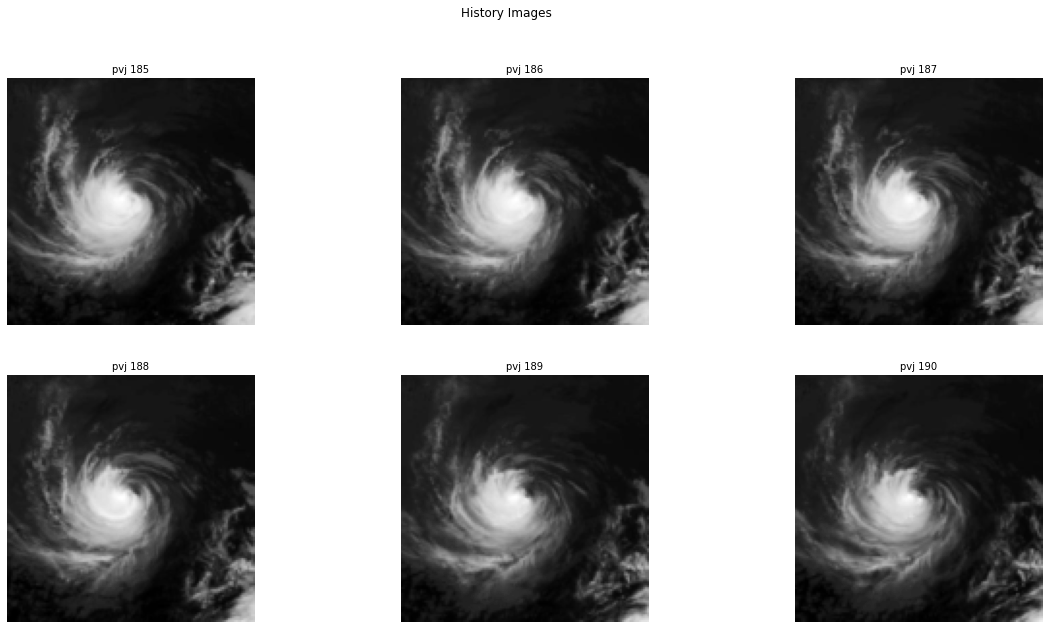

ConvLSTM(
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(65, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): ConvLSTMCell(
      (conv): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (conv): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [14]:
# 设置保存目录
output_dir = '/root/dashuju/predicted_images'
os.makedirs(output_dir, exist_ok=True)

# 从验证集提取历史图像路径和标签
history_image_paths = val_images[:6]
history_titles = [f'{extract_storm_id_and_time(path)[0]} {extract_storm_id_and_time(path)[1]}' for path in history_image_paths]

# 显示历史图像
val_sequences, val_targets = next(iter(val_loader))
history_images = [val_sequences[0][i] for i in range(6)]
plot_and_save_images(history_images, history_titles, title="History Images", save_path=os.path.join(output_dir, 'history_images.png'))

# 预测图像和真实图像的标签
predicted_titles = [f'Predicted Frame {i+1} ({val_image_info[6 + i][0]} {val_image_info[6 + i][1]})' for i in range(3)]
real_titles = [f'Real Frame {i+1} ({val_image_info[6 + i][0]} {val_image_info[6 + i][1]})' for i in range(3)]
combined_titles = predicted_titles + real_titles

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from scipy.stats import entropy
from torchvision import transforms

In [ ]:
real_titles = ['Real Image 1', 'Real Image 2', 'Real Image 3']
predicted_titles = ['Predicted Image 1', 'Predicted Image 2', 'Predicted Image 3']

In [16]:
"""
# 计算评估指标和信息熵
metrics = {
    'mse': [],
    'psnr': [],
    'ssim': [],
    'entropy_real': [],
    'entropy_pred': []
}

# 计算信息熵
def calculate_entropy(image):
    hist, _ = np.histogram(image, bins=256, range=(0, 1))
    hist = hist / np.sum(hist)
    e = entropy(hist, base=2)
    return e

for real_img, pred_img in zip(real_future_images, predicted_images):
    real_img_np = real_img.squeeze().cpu().numpy() 
    pred_img_np = pred_img.squeeze().cpu().numpy()
    
    mse = mean_squared_error(real_img_np, pred_img_np)
    psnr = peak_signal_noise_ratio(real_img_np, pred_img_np, data_range=255)
    ssim = structural_similarity(real_img_np, pred_img_np, data_range=255)
    entropy_real = calculate_entropy(real_img_np)
    entropy_pred = calculate_entropy(pred_img_np)
    
    metrics['mse'].append(mse)
    metrics['psnr'].append(psnr)
    metrics['ssim'].append(ssim)
    metrics['entropy_real'].append(entropy_real)
    metrics['entropy_pred'].append(entropy_pred)

# 绘制预测图像和真实图像，并显示评估指标和信息熵
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, (real_img, pred_img) in enumerate(zip(real_future_images, predicted_images)):
    real_img = denormalize(real_img).numpy().transpose(1, 2, 0).squeeze()
    pred_img = denormalize(pred_img).numpy().transpose(1, 2, 0).squeeze()
    #real_img_np = real_img.numpy().transpose(1, 2, 0).squeeze()
    #pred_img_np = pred_img.numpy().transpose(1, 2, 0).squeeze()
    axes[0, i].imshow(real_img, cmap='gray')
    axes[0, i].set_title(real_titles[i], fontsize=10)
    axes[0, i].axis('off')
    
    axes[1, i].imshow(pred_img, cmap='gray')
    axes[1, i].set_title(predicted_titles[i], fontsize=10)
    axes[1, i].axis('off')
    
    # 显示信息熵
    axes[0, i].text(0.5, 1.12, f'Entropy_real: {metrics["entropy_real"][i]:.4f}', ha='center', va='top', transform=axes[0, i].transAxes, fontsize=10)
    axes[1, i].text(0.5, 1.12, f'Entropy_pred: {metrics["entropy_pred"][i]:.4f}', ha='center', va='top', transform=axes[1, i].transAxes, fontsize=10)

    # 显示评估指标
    metric_text = f'MSE: {metrics["mse"][i]:.4f}\nPSNR: {metrics["psnr"][i]:.2f} dB\nSSIM: {metrics["ssim"][i]:.4f}'
    fig.text(0.23 + 0.28 * i, 0.03, metric_text, ha='center', fontsize=12)  # 调整 x 位置

plt.suptitle("Predicted vs Real Future Images",fontsize=15)
plt.savefig(os.path.join(output_dir, '/root/dashuju/image/predicted_vs_real_images.png'))
plt.show()
"""

'\n# 计算评估指标和信息熵\nmetrics = {\n    \'mse\': [],\n    \'psnr\': [],\n    \'ssim\': [],\n    \'entropy_real\': [],\n    \'entropy_pred\': []\n}\n\n# 计算信息熵\ndef calculate_entropy(image):\n    hist, _ = np.histogram(image, bins=256, range=(0, 1))\n    hist = hist / np.sum(hist)\n    e = entropy(hist, base=2)\n    return e\n\nfor real_img, pred_img in zip(real_future_images, predicted_images):\n    real_img_np = real_img.squeeze().cpu().numpy() \n    pred_img_np = pred_img.squeeze().cpu().numpy()\n    \n    mse = mean_squared_error(real_img_np, pred_img_np)\n    psnr = peak_signal_noise_ratio(real_img_np, pred_img_np, data_range=255)\n    ssim = structural_similarity(real_img_np, pred_img_np, data_range=255)\n    entropy_real = calculate_entropy(real_img_np)\n    entropy_pred = calculate_entropy(pred_img_np)\n    \n    metrics[\'mse\'].append(mse)\n    metrics[\'psnr\'].append(psnr)\n    metrics[\'ssim\'].append(ssim)\n    metrics[\'entropy_real\'].append(entropy_real)\n    metrics[\'entropy

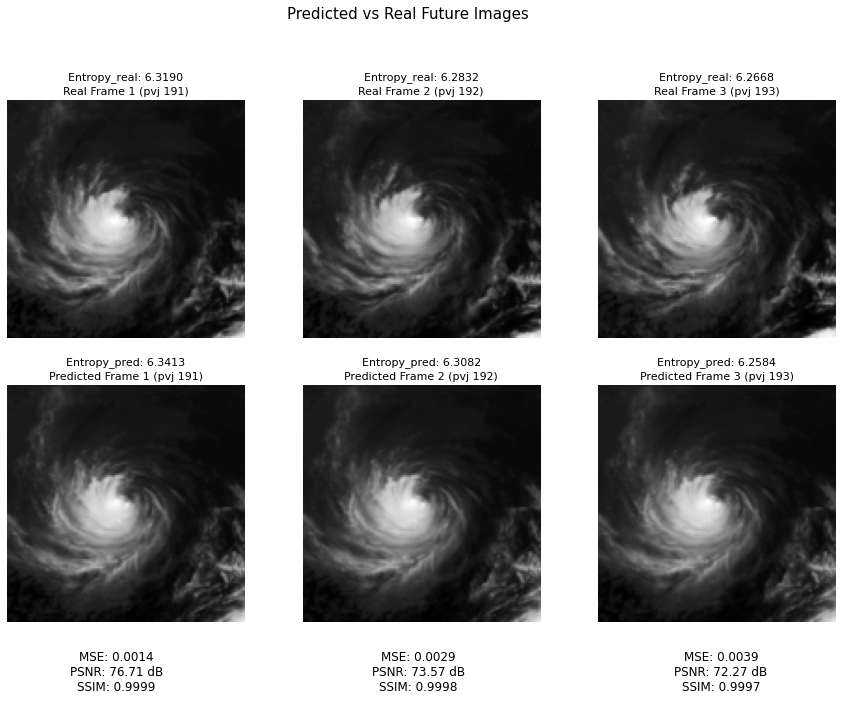

In [20]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from scipy.stats import entropy

# 设置保存目录
output_dir = '/root/dashuju/predicted_images'
os.makedirs(output_dir, exist_ok=True)

# 反归一化函数
def denormalize(tensor):
    return tensor * 255.0

# 计算信息熵的辅助函数
def calculate_entropy(image):
    hist, _ = np.histogram(image, bins=256, range=(0, 1))
    hist = hist / np.sum(hist)
    e = entropy(hist, base=2)
    return e

# 计算评估指标和信息熵
metrics = {
    'mse': [],
    'psnr': [],
    'ssim': [],
    'entropy_real': [],
    'entropy_pred': []
}

for real_img, pred_img in zip(real_future_images, predicted_images):
    real_img_np = real_img.squeeze().cpu().numpy() 
    pred_img_np = pred_img.squeeze().cpu().numpy()
    
    mse = mean_squared_error(real_img_np, pred_img_np)
    psnr = peak_signal_noise_ratio(real_img_np, pred_img_np, data_range=255)
    ssim = structural_similarity(real_img_np, pred_img_np, data_range=255)
    entropy_real = calculate_entropy(real_img_np)
    entropy_pred = calculate_entropy(pred_img_np)
    
    metrics['mse'].append(mse)
    metrics['psnr'].append(psnr)
    metrics['ssim'].append(ssim)
    metrics['entropy_real'].append(entropy_real)
    metrics['entropy_pred'].append(entropy_pred)

# 绘制预测图像和真实图像，并显示评估指标和信息熵
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, (real_img, pred_img) in enumerate(zip(real_future_images, predicted_images)):
    real_img_np = real_img.squeeze().cpu().numpy()
    pred_img_np = pred_img.squeeze().cpu().numpy()

    if real_img_np.ndim == 3 and real_img_np.shape[0] == 1:  # 如果是灰度图像，移除通道维度
        real_img_np = real_img_np.squeeze(0)
    if pred_img_np.ndim == 3 and pred_img_np.shape[0] == 1:  # 如果是灰度图像，移除通道维度
        pred_img_np = pred_img_np.squeeze(0)

    axes[0, i].imshow(real_img_np, cmap='gray')
    axes[0, i].set_title(real_titles[i], fontsize=11)
    axes[0, i].axis('off')
    axes[0, i].text(0.5, 1.12, f'Entropy_real: {metrics["entropy_real"][i]:.4f}', ha='center', va='top', transform=axes[0, i].transAxes, fontsize=11)
    
    axes[1, i].imshow(pred_img_np, cmap='gray')
    axes[1, i].set_title(predicted_titles[i], fontsize=11)
    axes[1, i].axis('off')
    axes[1, i].text(0.5, 1.12, f'Entropy_pred: {metrics["entropy_pred"][i]:.4f}', ha='center', va='top', transform=axes[1, i].transAxes, fontsize=11)

    # 显示评估指标
    metric_text = f'MSE: {metrics["mse"][i]:.4f}\nPSNR: {metrics["psnr"][i]:.2f} dB\nSSIM: {metrics["ssim"][i]:.4f}'
    fig.text(0.23 + 0.28 * i, 0.03, metric_text, ha='center', fontsize=12)  # 调整 x 位置

plt.subplots_adjust(top=0.85)
plt.suptitle("Predicted vs Real Future Images", fontsize=15)
plt.savefig(os.path.join(output_dir, 'predicted_vs_real_images.png'))
plt.show()


### 函数详细描述

#### 1. plot_and_save_images(images, titles=None, title='Images', save_path='')
- **功能**: 绘制并保存图像。
- **输入**:
  - `images` (list) - 图像列表，可以是PIL图像或Tensor。
  - `titles` (list) - 图像标题列表，可选。
  - `title` (str) - 总标题。
  - `save_path` (str) - 保存路径，可选。
- **输出**: 无。
- **实现思路**:
  - 创建子图，并绘制每个图像。
  - 如果提供了标题，则设置每个子图的标题。
  - 保存图像并显示。

### 2.预测和评估过程

1. **从验证集中选取样本**
2. **进行连续预测**: 使用模型进行连续三次预测，每次预测后将预测结果添加到序列中。
3. **从验证集中提取真实的未来三帧图像**: 提取验证集中对应的真实未来三帧图像。
4. **绘制历史图像**: 从验证集提取历史图像路径和标签，并使用`plot_and_save_images`函数绘制和保存。
5. **评估预测结果**:
   - 定义评估指标（MSE、PSNR、SSIM）和信息熵的计算方法。
   - 对每一对真实图像和预测图像，计算评估指标和信息熵，并记录下来。
6. **绘制预测图像和真实图像，并显示评估指标和信息熵**:
   - 创建子图，并绘制每一对真实图像和预测图像。
   - 显示每张图像的标题和评估指标。

### 测试集图像应用及绘制

In [23]:
import os
import re
import zipfile
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

# 从文件名中提取数字的辅助函数
def extract_number(filename):
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else 0

# 加载并排序图像文件
def load_images_sorted(directory):
    images = []
    for root, _, files in os.walk(directory):
        for fname in files:
            if fname.endswith('.jpg'):
                full_path = os.path.join(root, fname)
                images.append(full_path)
    images.sort(key=extract_number)
    return images

# 从文件名中提取风暴ID和时间的辅助函数
def extract_storm_id_and_time(filepath):
    filename = os.path.basename(filepath)
    parts = filename.split('_')
    storm_id = parts[0]
    time = parts[1].split('.')[0]
    return storm_id, time

# 提取所有图像信息的辅助函数
def extract_all_image_info(image_paths):
    all_image_info = []
    for path in image_paths:
        storm_id, time = extract_storm_id_and_time(path)
        all_image_info.append((storm_id, time))
    return all_image_info

# 解压缩文件
def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# 数据目录
zip_path = '/root/dashuju/test/test.zip'
extract_to = '/root/dashuju/data/testoutput'
extract_zip(zip_path, extract_to)

all_images = load_images_sorted(extract_to)

# 按风暴ID分组
storm_groups = defaultdict(list)
for img in all_images:
    storm_id, _ = extract_storm_id_and_time(img)
    storm_groups[storm_id].append(img)

# 分别对每个风暴类型按照比例进行划分
train_images = []
val_images = []
split_ratio = 0.8

for storm_id, images in storm_groups.items():
    split_point = int(len(images) * split_ratio)
    train_images.extend(images[:split_point])
    val_images.extend(images[split_point:])

# 提取训练集和验证集的所有图片信息
train_image_info = extract_all_image_info(train_images)
val_image_info = extract_all_image_info(val_images)

# 数据集类定义
class TyphoonDataset(Dataset):
    def __init__(self, image_paths, sequence_length=5, transform=None):
        self.image_paths = image_paths
        self.sequence_length = sequence_length
        self.transform = transform or transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.image_paths) - self.sequence_length + 1

    def __getitem__(self, idx):
        sequence_paths = self.image_paths[idx:idx + self.sequence_length]
        imgs = [Image.open(img_path).convert('RGB') for img_path in sequence_paths]
        if self.transform:
            imgs = [self.transform(img) for img in imgs]
        sequences = torch.stack(imgs[:-1])
        target = imgs[-1]  # 确保目标图像是 [1, height, width]
        return sequences, target

# 创建数据集和数据加载器
train_dataset = TyphoonDataset(train_images, sequence_length=7)  # 包含10个输入帧和1个输出帧
val_dataset = TyphoonDataset(val_images, sequence_length=7)
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=False, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=6, shuffle=False, drop_last=True)

"""
# 打印训练集和验证集的图片信息
print("Training set image info:")
for info in train_image_info:
    print(info)

print("\nValidation set image info:")
for info in val_image_info:
    print(info)
"""

'\n# 打印训练集和验证集的图片信息\nprint("Training set image info:")\nfor info in train_image_info:\n    print(info)\n\nprint("\nValidation set image info:")\nfor info in val_image_info:\n    print(info)\n'

In [24]:
import torch
import torch.nn as nn

class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, output_dim, bias=True):
        super(ConvLSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.bias = bias
        self.cell_list = nn.ModuleList()
        
        for i in range(self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i-1]
            self.cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                               hidden_dim=self.hidden_dim[i],
                                               kernel_size=self.kernel_size,
                                               bias=self.bias))
        
        self.conv = nn.Conv2d(in_channels=self.hidden_dim[-1],
                              out_channels=self.output_dim,
                              kernel_size=1,
                              padding=0,
                              bias=True)

    def forward(self, input_tensor, hidden_state=None):
        b, seq_len, _, h, w = input_tensor.size()
        if hidden_state is None:
            hidden_state = self._init_hidden(batch_size=b, image_size=(h, w))
        
        layer_output_list = []
        last_state_list = []

        cur_layer_input = input_tensor
        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :], cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append((h, c))

        predictions = self.conv(layer_output_list[-1][:, -1, :, :, :])
        return predictions, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states


In [25]:
# 加载模型
model = ConvLSTM(input_dim=1, hidden_dim=[64, 64], kernel_size=(1, 1), num_layers=2, output_dim=1, bias=True)
checkpoint = torch.load('/root/dashuju/model/model2-6张.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.cuda()
model.eval()

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
# 绘制图像的函数
def plot_and_save_images(images, titles=None, title='Images', save_path=''):
    num_images = len(images)
    fig, axes = plt.subplots(2, num_images // 2, figsize=(20, 10))
    axes = axes.flatten()
    for i, img_tensor in enumerate(images):
        if isinstance(img_tensor, torch.Tensor):
            # img_tensor = denormalize(img_tensor)  # 反归一化
            img = transforms.ToPILImage()(img_tensor)  # 转换为 PIL 图像
        else:
            img = img_tensor
        axes[i].imshow(img, cmap='gray')
        if titles:
            axes[i].set_title(titles[i], fontsize=10)
        axes[i].axis('off')
    fig.suptitle(title)
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [27]:
import matplotlib.pyplot as plt

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 从验证集中选取一个样本
val_sequences, val_targets = next(iter(val_loader))
initial_sequence = val_sequences[0:1].to(device)  # 选择第一个样本

predicted_images = []
current_sequence = initial_sequence

# 进行三次连续预测
for _ in range(3):
    with torch.no_grad():
        prediction, _ = model(current_sequence)
        prediction = prediction.unsqueeze(1)  # 确保维度正确
        predicted_images.append(prediction.cpu().squeeze(0).squeeze(0))
        
        # 更新序列：移除第一帧，加入新预测的帧
        current_sequence = torch.cat((current_sequence[:, 1:, :, :, :], prediction), dim=1)

# 从val_targets提取真实的未来三帧图像
real_future_images = [val_targets[i].cpu() for i in range(3)]


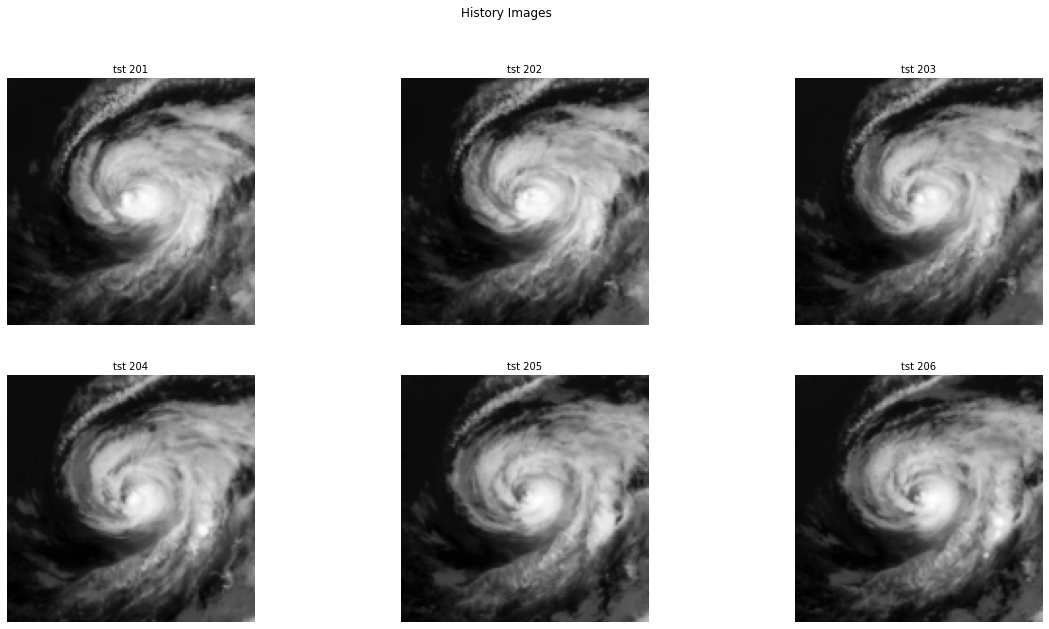

ConvLSTM(
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(65, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): ConvLSTMCell(
      (conv): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (conv): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [28]:
# 设置保存目录
output_dir = '/root/dashuju/predicted_images'
os.makedirs(output_dir, exist_ok=True)

# 从验证集提取历史图像路径和标签
history_image_paths = val_images[:6]
history_titles = [f'{extract_storm_id_and_time(path)[0]} {extract_storm_id_and_time(path)[1]}' for path in history_image_paths]

# 显示历史图像
val_sequences, val_targets = next(iter(val_loader))
history_images = [val_sequences[0][i] for i in range(6)]
plot_and_save_images(history_images, history_titles, title="History Images", save_path=os.path.join(output_dir, '方案3_6张_test_history_images.png'))

# 预测图像和真实图像的标签
predicted_titles = [f'Predicted Frame {i+1} ({val_image_info[6 + i][0]} {val_image_info[6 + i][1]})' for i in range(3)]
real_titles = [f'Real Frame {i+1} ({val_image_info[6 + i][0]} {val_image_info[6 + i][1]})' for i in range(3)]
combined_titles = predicted_titles + real_titles

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Image 1:
MSE: 0.0033
PSNR: 73.00 dB
SSIM: 0.9998
Entropy (Real): 7.1239
Entropy (Pred): 7.0834
---------------------------
Image 2:
MSE: 0.0063
PSNR: 70.13 dB
SSIM: 0.9996
Entropy (Real): 7.1323
Entropy (Pred): 7.0150
---------------------------
Image 3:
MSE: 0.0078
PSNR: 69.20 dB
SSIM: 0.9993
Entropy (Real): 7.1434
Entropy (Pred): 6.9545
---------------------------


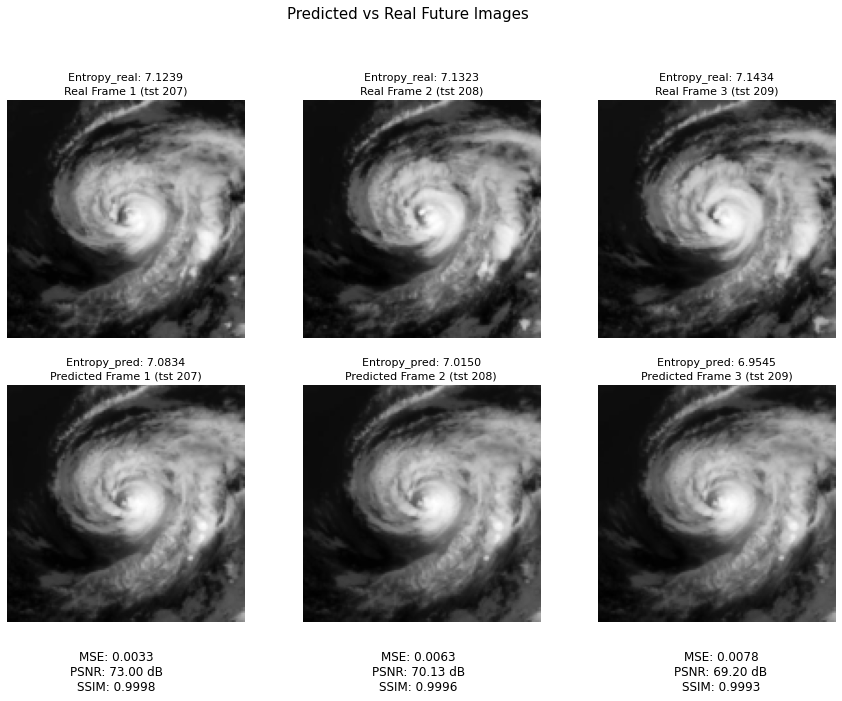

In [29]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from scipy.stats import entropy

# 设置保存目录
output_dir = '/root/dashuju/predicted_images'
os.makedirs(output_dir, exist_ok=True)

# 反归一化函数
def denormalize(tensor):
    return tensor * 255.0

# 计算信息熵的辅助函数
def calculate_entropy(image):
    hist, _ = np.histogram(image, bins=256, range=(0, 1))
    hist = hist / np.sum(hist)
    e = entropy(hist, base=2)
    return e

# 计算评估指标和信息熵
metrics = {
    'mse': [],
    'psnr': [],
    'ssim': [],
    'entropy_real': [],
    'entropy_pred': []
}

for real_img, pred_img in zip(real_future_images, predicted_images):
    real_img_np = real_img.squeeze().cpu().numpy() 
    pred_img_np = pred_img.squeeze().cpu().numpy()
    
    mse = mean_squared_error(real_img_np, pred_img_np)
    psnr = peak_signal_noise_ratio(real_img_np, pred_img_np, data_range=255)
    ssim = structural_similarity(real_img_np, pred_img_np, data_range=255)
    entropy_real = calculate_entropy(real_img_np)
    entropy_pred = calculate_entropy(pred_img_np)
    
    metrics['mse'].append(mse)
    metrics['psnr'].append(psnr)
    metrics['ssim'].append(ssim)
    metrics['entropy_real'].append(entropy_real)
    metrics['entropy_pred'].append(entropy_pred)

    # 在控制台输出指标值
    print(f'Image {len(metrics["mse"])}:')
    print(f'MSE: {mse:.4f}')
    print(f'PSNR: {psnr:.2f} dB')
    print(f'SSIM: {ssim:.4f}')
    print(f'Entropy (Real): {entropy_real:.4f}')
    print(f'Entropy (Pred): {entropy_pred:.4f}')
    print('---------------------------')

# 绘制预测图像和真实图像，并显示评估指标和信息熵
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, (real_img, pred_img) in enumerate(zip(real_future_images, predicted_images)):
    real_img_np = real_img.squeeze().cpu().numpy()
    pred_img_np = pred_img.squeeze().cpu().numpy()

    if real_img_np.ndim == 3 and real_img_np.shape[0] == 1:  # 如果是灰度图像，移除通道维度
        real_img_np = real_img_np.squeeze(0)
    if pred_img_np.ndim == 3 and pred_img_np.shape[0] == 1:  # 如果是灰度图像，移除通道维度
        pred_img_np = pred_img_np.squeeze(0)

    axes[0, i].imshow(real_img_np, cmap='gray')
    axes[0, i].set_title(real_titles[i], fontsize=11)
    axes[0, i].axis('off')
    axes[0, i].text(0.5, 1.12, f'Entropy_real: {metrics["entropy_real"][i]:.4f}', ha='center', va='top', transform=axes[0, i].transAxes, fontsize=11)
    
    axes[1, i].imshow(pred_img_np, cmap='gray')
    axes[1, i].set_title(predicted_titles[i], fontsize=11)
    axes[1, i].axis('off')
    axes[1, i].text(0.5, 1.12, f'Entropy_pred: {metrics["entropy_pred"][i]:.4f}', ha='center', va='top', transform=axes[1, i].transAxes, fontsize=11)

    # 显示评估指标
    metric_text = f'MSE: {metrics["mse"][i]:.4f}\nPSNR: {metrics["psnr"][i]:.2f} dB\nSSIM: {metrics["ssim"][i]:.4f}'
    fig.text(0.23 + 0.28 * i, 0.03, metric_text, ha='center', fontsize=12)  # 调整 x 位置

plt.subplots_adjust(top=0.85)
plt.suptitle("Predicted vs Real Future Images", fontsize=15)
plt.savefig(os.path.join(output_dir, '方案3_6张_predicted_vs_real_images.png'))
plt.show()
